In the previous [post](https://lucasvw.github.io/posts/15_rnn/) we went in detail through Recurrent Neural Networks (RNN's). We looked at how they are similar to MLPs and how they allow for a large improvement in processing data.

One main problem with RNN's is that it's still relatively difficult for the model to maintain information on something that has happened a long time ago. If in one sentence the subject turns out to be a male, then in the next sentence the model should still remember this, and use "he" as a pronoun when referring to this person. One way to do this, is by extending the sequence length to large values, but this brings its own problems exploding and or vanishing gradients because of the increased depth of the model. 

:::{.callout-note}
Exploding and vanishing gradients is a general problem of neural networks. In an [earlier](https://lucasvw.github.io/posts/11_nntrain_activations/#iterative-matrix-multiplications) blog post we discussed this in the context of deep neural networks for vision applications.
:::

Although there are multiple ways of dealing with this problem such as normalization and initialization, the Long short-term memory (LSTM) layer is another way to deal with this. Instead of increasing the sequence length (and thus increasing the depth of the model), it aims to have a better technique for remembering the past.

## Architecture and Intuition

To discuss the LSTM architecture, let's start by looking one last time back at RNN's. In the previous post, we ended up with the following diagram displaying an (unrolled) 1 layer RNN with a sequence length of 3:

![Unrolled 1 layer RNN processes a single batch with a sequence length of 3](rnn3.drawio.png)

If we zoom in on the processing of one token (timestep) we can generalize this to the image below. In the middle, we have the RNN Cell which in terms of the image above, is the combination of the addition and the blue arrow (the hidden to hidden linear layer). On the left we see the previous hidden state entering the RNN cell, and on the bottom we have the embedding activations of the input entering the cell (this is what comes out of the red arrow in the image above. The computation of the new hidden state (on the right), is simply the addition of both activations and a linear layer followed by a Relu activation. This hidden state is passed to the next token as well as to the output layer (the yellow arrow in the previous diagrams).

![Details of the RNN cell](rnncell.drawio.png)

With this representation, it becomes easy to understand the LSTM. Since the only difference is the content of this RNN cell!

On the bottom left we see the (embedding activations of the) inputs $x$ and the hidden state $h$, similar to what we have seen in RNN's.

The first thing that's different from an RNN, is that the LSTM architecture uses a second (cell) state $c$ (top left) besides the  hidden state $h$. Whereas in the RNN the hidden state is responsible for both keeping a memory of everything that has happened in the past, as well as having information for predicting the next token. These tasks are split in the LSTM, the cell state is responsible for keeping a memory and the hidden state is concerned with the next token.

Furthermore, the cell state *update* is not going through a neural network layer (the orange boxes), instead the LSTM can update this state by two element-wise operations (blue circles). This allows it to keep information (remember) for a long time.

The cell state is first multiplied by the output of the forget gate. These outputs first go through a sigmoid non-linearity and are thus between 0 and 1. Multiplications with 1's mean that (parts of the) cell state is kept whereas values of 0 mean that (parts of the) cell state is removed (*forgotton*). The inputs to the forget gate are the concatenation of the previous hidden state and the (embedding activations) of the current input. However, there exist other LSTM's where the previous cell state is concatenated to the inputs as well (for example in the Peephole LSTM, in which all the gates get an input from the cell state).

![](lstmcell.drawio.png)

In the two gates that follow (input gate and cell gate), information is prepared to be added to the cell state. The input gate is outputting activations between 0 and 1 and is responsible for determining which cell state to update, and the cell gate is responsible for creating new candidate values. These two are multiplied together before they are being added to the cell state. 

Finally, the new hidden state gets computed and is basically a filtered version of the (updated) cell state. The cell state is first put through a tanh activation (values between -1 and 1) and then multiplied by sigmoid layer. This sigmoid layer is basically deciding which values of the cell state it wants to use for predicting the next token. The new hidden state is both outputted to the right (for the processing of the next token / timestep) as well as to the top (to be passed to the output layer similarly as in an RNN).

Now let's discuss this process and the concepts in terms of a continuous text generation task. The cell state represents all the information about what has been generated previously: the subjects that the text is talking about, what is going on with the subjects, the style the text is written in (present tense, past tense etc). The multiplication of this cell state with the outputs of the forget gate, allow elements of the cell state to be forgotten. For example, if the current token (word) indicates that we are switching from present tense to past tense, the forget gate's output should let the cell state know to drop this information. The next two gates are responsible for adding new information into the cell state: e.g. preparing a representation of the *past tense*. Finally, the output gate should prepare a filter that the next word (let's say a verb) should be created in the current style (which has now switched to past tense). 

Although I have read about this intuition in multiple places, I am not sure whether it's exactly correct. Nor whether it has been proven that an LSTM is doing things exactly in this way. My (current) belief is that researchers often not exactly know whether a certain intuition is correct or not. But that we simply try something, in which we can *imagine that a neural network could learn something in a certain way*. Whether the network is actually doing that thing, that we thought it would do, is not always clear. But I guess as long as it's beneficial to performance, that's the first thing to be happy about.

Now that we understand the LSTM, let's code it up!

## Data
Everything starts with training data, for a description see an earlier [post](https://lucasvw.github.io/posts/13_ngram/)

In [ ]:
#| code-fold: true

import random
from functools import reduce, partial
from pathlib import Path
from urllib.request import urlretrieve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc

from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *
from nntrain.acceleration import *
from nntrain.rnn import *
########### Load the data ###########
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)
path = path / 'names.txt'
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

_ = urlretrieve(url, path)

with open(path, 'r') as f:
    lines = f.read().splitlines()
    
random.seed(42)
random.shuffle(lines)

train_size=0.8
val_size=0.1

train_lines = lines[0:int(train_size * len(lines))]
val_lines = lines[int(train_size * len(lines)): int((train_size + val_size) * len(lines))]

### Create vocabulary and mappings ###
unique_chars = list(set("".join(lines)))
unique_chars.sort()
vocabulary = ['.'] + unique_chars

c2i = {c:i for i, c in enumerate(vocabulary)}
i2c = {i:c for i, c in enumerate(vocabulary)}

Last [post](https://lucasvw.github.io/posts/15_rnn/) the `SequentialDataset` and the `VerticalSampler` were introduced to load data in a way that fits RNN's (and thus LSTM's):

In [ ]:
def get_dls(context_length, batch_size):
    train_ds = SequentialDataset(train_lines, c2i, context_length)
    valid_ds = SequentialDataset(val_lines, c2i, context_length)
        
    train_dl = torch.utils.data.DataLoader(train_ds, shuffle=False, sampler=VerticalSampler(train_ds, batch_size), batch_size=batch_size)
    valid_dl = torch.utils.data.DataLoader(valid_ds, shuffle=False, sampler=VerticalSampler(valid_ds, batch_size), batch_size=batch_size)

    return DataLoaders(train_dl, valid_dl)

## Manual LSTM

The creation of an LSTM cell is relatively straight-forward, by making use of the diagram we can simply put the arithmetic in a class:

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()        
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate  = nn.Linear(ni + nh, nh)
        self.cell_gate   = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)
        
    def forward(self, inp, h, c):
        # inp  [bs, ni]
        # h [bs, nh]
        # c [bs, nh]
        
        h = torch.cat([h, inp], dim=1)              # [bs, ni+nh]
        
        forget = torch.sigmoid(self.forget_gate(h)) # [bs, nh]
        c = forget * c                              # [bs, nh]   
        
        inp = torch.sigmoid(self.input_gate(h))     # [bs, nh]
        cell = torch.tanh(self.cell_gate(h))        # [bs, nh]
        
        inp = inp * cell                            # [bs, nh]
        c = c + inp                                 # [bs, nh]
        
        h = torch.sigmoid(self.output_gate(h))      # [bs, nh]
        h = h * torch.tanh(c)                       # [bs, nh]
        
        return h, c

Now let's create an `LSTMNet` that uses this `LSTMCell`. This is a very similar network as the RNN we created in the previous post, we just have to iterate manually through the sequence length and sequentially call the inputs on the cell passing in the hidden and cell state:

In [ ]:
class LSTMNet(nn.Module):
    
    def __init__(self, c2i, embedding_dim, hidden_size, bs):
        super().__init__()
        self.c2i            = c2i
        self.bs             = bs
        self.embedding_dim  = embedding_dim
        self.hidden_size    = hidden_size
        # register as buffer so that its moved to the device by the DeviceS Subscriber
        self.register_buffer('h', torch.zeros((bs, self.hidden_size)))
        self.register_buffer('c', torch.zeros((bs, self.hidden_size)))
        
        self.input2hidden   = nn.Embedding(len(c2i), embedding_dim)
        self.lstm           = LSTMCell(embedding_dim, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        outputs = []
        for i in range(inputs.shape[1]):
            self.h, self.c = self.lstm(inputs[:,i,:], self.h, self.c)
            outputs += [self.h]
        self.h = self.h.detach()
        self.c = self.c.detach()
        return self.hidden2out(torch.stack(outputs, dim=1))
    
    def reset_hidden_state(self):
        device = self.h.get_device()
        self.h = torch.zeros_like(self.h).to(device)
        self.c = torch.zeros_like(self.c).to(device)

And let's see how it performs:

epoch,mode,loss
0,train,2.413
0,eval,2.166
1,train,2.089
1,eval,2.066
2,train,1.974
2,eval,2.003
3,train,1.846
3,eval,1.963
4,train,1.711
4,eval,1.950


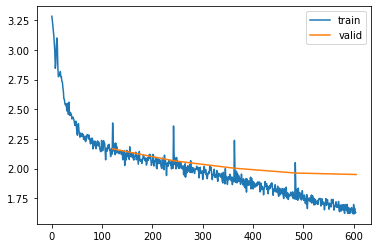

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 1000
embedding_dim  = 100

dls = get_dls(context_length, bs)
lstm = LSTMNet(c2i, embedding_dim, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(lstm, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

With the 2 layer RNN from the previous post, we reached an evaluation loss of 1.976, this is thus a nice improvement!

## PyTorch LSTM

When we use the default PyTorch LSTM, the network is practically identical to the RNN we created in the previous post:

In [ ]:
class PyTorchLSTM(nn.Module):
    def __init__(self, c2i, embedding_dim, hidden_size, bs, layers=1):
        super().__init__()
        self.c2i = c2i
        self.bs = bs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.register_buffer('h', torch.zeros((layers, bs, self.hidden_size)))
        self.register_buffer('c', torch.zeros((layers, bs, self.hidden_size)))
        
        self.input2hidden   = nn.Embedding(len(c2i), embedding_dim)               
        self.lstm = nn.LSTM(embedding_dim, hidden_size, layers, batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        hs, state = self.lstm(inputs, (self.h, self.c))
        self.h = state[0].detach()
        self.c = state[1].detach()
        return self.hidden2out(hs)
    
    def reset_hidden_state(self):
        device = self.h.get_device()
        self.h = torch.zeros_like(self.h).to(device)
        self.c = torch.zeros_like(self.c).to(device)
    

epoch,mode,loss
0,train,2.419
0,eval,2.163
1,train,2.087
1,eval,2.064
2,train,1.972
2,eval,2.004
3,train,1.846
3,eval,1.966
4,train,1.713
4,eval,1.952


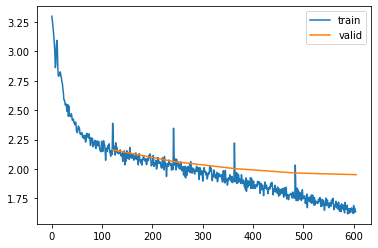

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 1000
embedding_dim  = 100
layers         = 1

dls = get_dls(context_length, bs)
lstm = PyTorchLSTM(c2i, embedding_dim, n_h, bs, layers=layers)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(lstm, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

The result is similar to the manual LSTM.

## Sampling names

Last but not least, let's sample some names with our LSTM:

In [ ]:
@fc.patch
def generate(self:PyTorchLSTM, n=10, generator=None):
    # For unbatched input we need a 2D hidden state tensor of size [1, hidden_size]
    self.h = torch.zeros((self.h.shape[0], self.hidden_size)).cuda()
    self.c = torch.zeros((self.h.shape[0], self.hidden_size)).cuda()
    
    names = []
    for i in range(n):
        name = '.'
        while True:
            idx = torch.tensor([c2i[name[-1]]]).cuda()
            logits = self.forward(idx)
            s = torch.multinomial(F.softmax(logits, dim=1), 1, generator=generator)
            c = i2c[s.item()]
            name += c
            if c == '.':
                names.append(name)
                break
    return names

In [ ]:
lstm.generate()

['.misdell.',
 '.treniya.',
 '.malu.',
 '.jamem.',
 '.diln.',
 '.savina.',
 '.nayelly.',
 '.genise.',
 '.zia.',
 '.wrenson.']